### 羅然莉 Shallow Machine Learning | SRCNN Revolution
---------------------------------------------------------------------------------------

**| 目的 |**  

- 利用 PyTorch 深度機器學習 CNN 模型進行高解析度影像生成的訓練（SRCNN），並實讀入低解析度的圖產出高解析度的圖。

**| 方法 |** 

- 先利用 Bicubic 將圖片縮小 1/2，再放大為 2 倍，最後放入所訓練的模型中，產出叫高解析度的圖片。
- 比較 Bicubic 放大的圖片解析度，以及模型生成的圖片的解析度。

**| 作業 |**       

- 讀入 pre-trained 的 pth 檔，再進行 3 次 training，並展示其  Train PSNR 與 Val PSNR 值。
- 測試 Set5 與 Set14 並展示 Test PSNR on Set5 與 Test PSNR on Set14。
- 寫一段程式實際對已訓練完成的 CNN 模型輸入任何一張影像，並生成相對應的一張高解度影像。

**| 資料來源 |**  

- 高解析度影像生成的深度學習機 SRCNN 檔案 

---------------------------------------------------------------------------------------

### **<font color=#4169e1> 讀取套件</font>**

In [140]:
import time
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from PIL import Image
import math

import torch
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import SRCNN_srcnn_4 as srcnn
from SRCNN_utils_0 import psnr
from SRCNN_utils_0 import (
    psnr, save_model, save_model_state, 
    save_plot, save_validation_results
)
from SRCNN_datasets_3 import get_datasets, get_dataloaders

---------------------------------------------------------------------------------------

### **<font color=#4169e1>（一）讀入 pre-trained 的 pth 檔，再進行 3 次 training，並展示其  Train PSNR 與 Val PSNR 值。</font>**

1. 下方程式讀入預訓練 model_ckpt.pth 檔(當中以訓練 100 個 epoch)，並再跑三次 epoch 訓練

2. 主要修改地方為： 
- 學習率改為 0.0001 （降低其收斂的數度，訓練可以迭代更多次）
- 將 TRAIN_LABEL 改為使用殘差
- Validation 的 loss 改為：criterion(torch.add(outputs,image_data), label) 讓殘差+模糊圖，可以與原圖進行比較

3. 最後的 Train PSNR 為：33.083 / Val PSNR : 29.239

In [3]:
# ------------------------------------ Set training epochs as 3 ------------------------------------

parser = argparse.ArgumentParser()
parser.add_argument(
    '-e', '--epochs', default=3, type=int, 
    help='number of epochs to train for'
)
parser.add_argument(
    '-w', '--weights', default='/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/outputs/result_4/model_ckpt.pth',
    help='weights/checkpoint path to resume training'
)

args, unknown = parser.parse_known_args()
args = vars(args)

# ------------------------------------ Learning parameters ------------------------------------

epochs = args['epochs'] # Number of epochs to train the SRCNN model for.
lr = 0.0001 # Learning rate. (修改了lr)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


TRAIN_LABEL_PATHS = '/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/input/t91_lr_patches_residual'
TRAIN_IMAGE_PATHS = '/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/input/t91_lr_patches'
VALID_LABEL_PATHS = '/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/input/test_hr'
VALID_IMAGE_PATHS = '/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/input/test_bicubic_rgb_2x'
SAVE_VALIDATION_RESULTS = True


os.makedirs('/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/outputs/valid_results_5', exist_ok=True)

# Initialize the model
print('Computation device: ', device)
model = srcnn.SRCNN().to(device)
model.load_state_dict(torch.load('/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/outputs/result_4/model.pth',map_location=torch.device('cpu')))
if args['weights'] is not None:
    print('Loading weights to resume training...')
    checkpoint = torch.load(args['weights'])
    model.load_state_dict(checkpoint['model_state_dict'])
print(model)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Loss function
criterion = nn.MSELoss()

dataset_train, dataset_valid = get_datasets(
    TRAIN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_valid)}")

def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # Zero grad the optimizer.
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)

        # Backpropagation.
        loss.backward()
        # Update the parameters.
        optimizer.step()

        # Add loss of each item (total items in a batch = batch size).
        running_loss += loss.item()
        # Calculate batch psnr (once every `batch_size` iterations).
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr


def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(torch.add(outputs,image_data), label)

            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, torch.add(outputs,image_data))
            running_psnr += batch_psnr

            # For saving the batch samples for the validation results
            # every 1 epoch
            if SAVE_VALIDATION_RESULTS and (epoch % 1) == 0: 
                save_validation_results(outputs, epoch, bi)

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr


# ------------------------------------ Main Code ------------------------------------
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)  
    val_epoch_loss, val_epoch_psnr = validate(model, valid_loader, epoch+1)   # 訓練完一個 epoch 做 validation
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    
    # Save model with all information every 1 epochs. Can be used 
    # resuming training.
    if (epoch+1) % 1 == 0:
        save_model(epoch, model, optimizer, criterion)   
    # Save the model state dictionary only every epoch. Small size, 
    # can be used for inference.
    save_model_state(model)   
    # Save the PSNR and loss plots every epoch.
    save_plot(train_loss, val_loss, train_psnr, val_psnr)

end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Computation device:  cpu
Loading weights to resume training...
SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)
Training samples: 22227
Validation samples: 19
Epoch 1 of 3


100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


Train PSNR: 33.081
Val PSNR: 29.237
Saving model...
Epoch 2 of 3


100%|██████████| 19/19 [00:05<00:00,  3.75it/s]


Train PSNR: 33.080
Val PSNR: 29.241
Saving model...
Epoch 3 of 3


100%|██████████| 19/19 [00:05<00:00,  3.72it/s]


Train PSNR: 33.082
Val PSNR: 29.239
Saving model...
Finished training in: 3.169 minutes


---------------------------------------------------------------------------------------

### **<font color=#4169e1>（二）測試 Set5 與 Set14 並展示 Test PSNR on Set5 與 Test PSNR on Set14</font>**

1. 下方程式則讀入未訓練過的圖檔，並觀察其表現

2. 主要修改的地方為：validation 的 batch_psnr 的計算：psnr(label, torch.add(outputs, image_data)) 

3. 測試出來的解果為： 
- set5 PSNR : 31.646626644789023
- set14 PSNR:27.80409984407741

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------ Testing parameters ------------------------------------

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in enumerate(dataloader):
            image_data = data[0].to(device)
            label = data[1].to(device)
            outputs = model(image_data)
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, torch.add(outputs, image_data))  
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

# The SRCNN dataset module.
class SRCNNDataset(Dataset):
    def __init__(self, image_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        # The high resolution ground truth label.
        label = Image.open(self.all_image_paths[index]).convert('RGB')
        w, h = label.size[:]
        # Convert to 2x bicubic.
        low_res_img = label.resize((int(w*0.5), int(h*0.5)), Image.BICUBIC)
        # The low resolution input image.
        image = low_res_img.resize((w, h), Image.BICUBIC)

        # Uncomment the below code to visualize the image for sanity check.
        # plt.figure(figsize=(12, 9))
        # plt.subplot(1, 2, 1)
        # plt.imshow(image)
        # plt.axis('off')
        # plt.subplot(1, 2, 2)
        # plt.imshow(label)
        # plt.axis('off')
        # plt.show()

        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)

        image = 255*(image-image.min())/(image.max()-image.min())
        image /= 255.
        label = 255*(label-image.min())/(label.max()-image.min())
        label /= 255.

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])

        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

# Prepare the datasets.
def get_datasets(
    image_paths
):
    dataset_test = SRCNNDataset(image_paths)
    return dataset_test

# Prepare the data loaders
def get_dataloaders(dataset_test):
    test_loader = DataLoader(
        dataset_test, 
        batch_size=1,
        shuffle=False
    )
    return test_loader


# ------------------------------------ Main Code ------------------------------------
if __name__ == '__main__':
    # Load the model.
    model = srcnn.SRCNN().to(device)
    model.load_state_dict(torch.load('/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/outputs/result_4/model.pth'))

    data_paths = [
        ['/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/input/Set5/original', 'Set5'],
        ['/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/input/Set14/original', 'Set14']
    ]

    l=[]
    for data_path in data_paths:
        dataset_test = get_datasets(data_path[0])
        test_loader = get_dataloaders(dataset_test)

        _, test_psnr = validate(model, test_loader, device)
        l.append(test_psnr)
        #print(f"Test PSNR on {data_path[1]}: {test_psnr:.3f}")
    print(f"set5 PSNR : {l[0]}\nset14 PSNR:{l[1]}")

set5 PSNR : 31.646626644789023
set14 PSNR:27.80409984407741


---------------------------------------------------------------------------------------

### **<font color=#4169e1>（三）寫一段程式實際對已訓練完成的 CNN 模型輸入任何一張影像，並生成相對應的一張高解度影像。</font>**

步驟：
1. 輸入一張 512*512 的圖片
2. 利用 BICUBIC 縮小成 1/2，再放大成 2 倍
3. 將 2 倍的 Bicubic 圖片輸入訓練好的模型中，（預期）輸出更清晰的圖片
4. 將圖片印出來比較

觀察：
- 以肉眼觀察，看不出 Bicubic 放大兩倍與 Model 生成圖片的差別

Original image dimensions: 512, 512


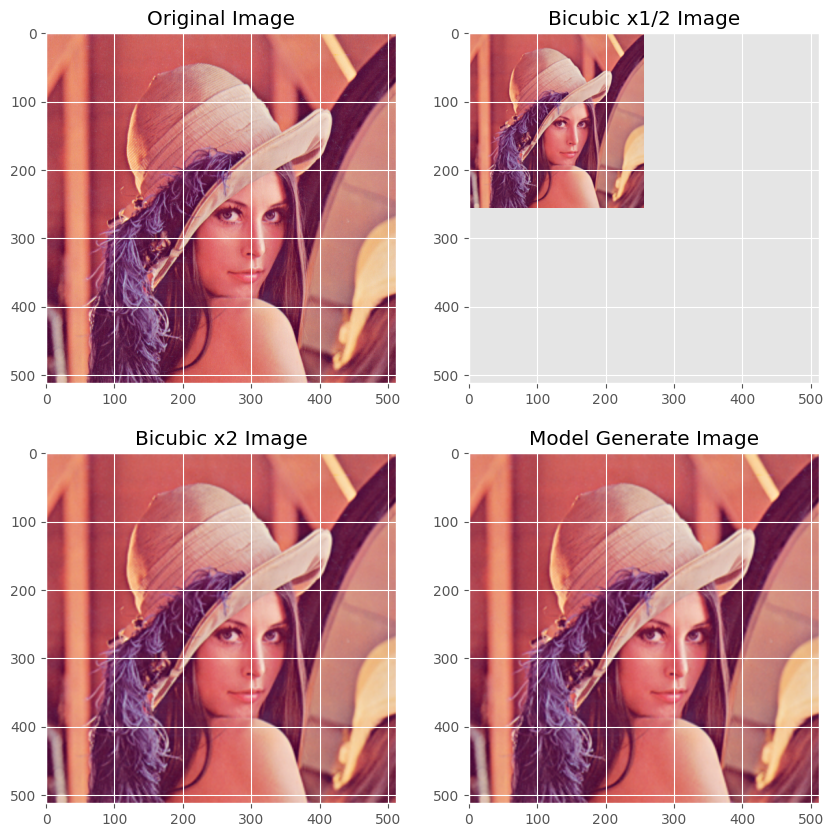

<Figure size 640x480 with 0 Axes>

In [146]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------ Input Image --------------------------------------------

orig_image_path = '/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/data/blurred4.png'

orig_img = Image.open(orig_image_path)
w, h = orig_img.size[:]
print(f"Original image dimensions: {w}, {h}")
orig_img.save('orig_image.png')

# ------------------------------------ BICUBIC ----------------------------------------------------

# 1/2 using BICUBIC.
scale_factor = 0.5
low_res_img = orig_img.resize((int(w*scale_factor), int(h*scale_factor)), Image.BICUBIC)

# Upscale using BICUBIC.
high_res_upscale = low_res_img.resize((w, h), Image.BICUBIC)
high_res_upscale.save('orig_img_hr_image.png')

# -------------------------------- Model: Generate Clear Picture  ------------------------------------

# Load Model
model = srcnn.SRCNN().to(device)
model.load_state_dict(torch.load('/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/SRCNN/outputs/result_3/model.pth'))
model.eval()

# Input Bicubic x2 picture
input_image_path = '/Users/ranli/Documents/python_ve/MS_Shallow_ML_3.10/orig_img_hr_image.png'

# Change Image type 
preprocess = transforms.Compose([
    transforms.ToTensor()
])
input_image = Image.open(input_image_path).convert('RGB')
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

# Predict wuth model
with torch.no_grad():
    output_batch = model(input_batch)

# Get the predict result
output_tensor = output_batch.squeeze(0)
output_image = transforms.ToPILImage()(output_tensor)

result_tensor = torch.add(input_tensor, output_tensor)
result_image = transforms.ToPILImage()(result_tensor.squeeze(0))

# Generate High resolution picture
output_image.save('path_to_output_image.png')

# ------------------------------------------- Show Image  -----------------------------------------------

m, n, _ = np.array(orig_img).shape

plt.figure(figsize=[10,10])
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.xlim(0, m)      
plt.ylim(n, 0) 
plt.imshow(orig_img)

plt.subplot(2, 2, 2)
plt.title('Bicubic x1/2 Image')
plt.xlim(0, m)      
plt.ylim(n, 0) 
plt.imshow(low_res_img)

plt.subplot(2, 2, 3)
plt.title('Bicubic x2 Image')
plt.xlim(0, m)      
plt.ylim(n, 0) 
plt.imshow(input_image)

plt.subplot(2, 2, 4)
plt.title('Model Generate Image')
plt.xlim(0, m)      
plt.ylim(n, 0) 
plt.imshow(result_image)
plt.show()

plt.tight_layout()

# Residual Image
# plt.subplot(1, 3, 2)    
# plt.title('Residual Image')
# plt.imshow(output_image)
# plt.xlim(0, m)      
# plt.ylim(n, 0) 

---------------------------------------------------------------------------------------

### **<font color=#4169e1>計算上述圖片的 PSNR </font>**

因肉眼較難看出 Bicubic 和 Model 生成的圖片的差異，筆者將兩者得 PSNR 印出來查看：
- Bicubic x2 PSNR : 32.994920816832014
- Modeal Generate Picture PSNR : 32.9929962307303       

結果反而兩倍的 Bicubic 表現得更好，模型的訓練還需加強

In [147]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------ PSNR calculation Definition ----------------------------------------------
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition

    Note that the output and label pixels (when dealing with images) should
    be normalized as the `max_val` here is 1 and not 255.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    diff = outputs - label
    rmse = math.sqrt(np.mean((diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR
    
# ------------------------------------ PSNR calculation Definition ----------------------------------------------

org_tensor = preprocess(orig_img)

q = psnr(org_tensor,input_tensor , max_val=1.)
print(f'Bicubic x2 PSNR:{q}')

p = psnr(org_tensor,result_tensor , max_val=1.)
print(f'Modeal Generate Picture PSNR:{p}')

Bicubic x2 PSNR:32.994920816832014
Modeal Generate Picture PSNR:32.9929962307303


---------------------------------------------------------------------------------------